In [49]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [50]:
# Mean and std of the pixels in the dataset
mean_gray = 0.1307
stddev_gray = 0.3081

# Transform the images to tensors and normalize
transforms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((mean_gray,),
                                 (stddev_gray,))])

# Load our datasets
train_dataset = datasets.MNIST(root = './data',
                               train = True,
                               transform = transforms)

test_dataset = datasets.MNIST(root = './data',
                               train = False,
                               transform = transforms)

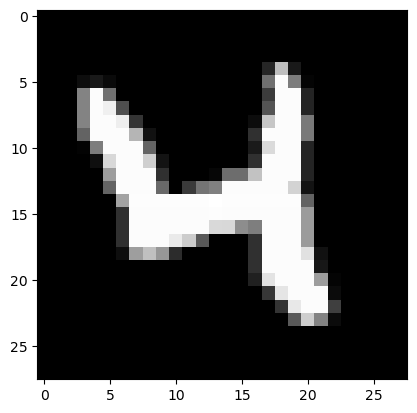

In [51]:
import matplotlib.pyplot as plt
random_image = train_dataset[20][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_image.reshape(28, 28), cmap="gray")

In [52]:
print(train_dataset[20][1])

4


In [53]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                         batch_size = batch_size,
                                         shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = batch_size,
                                         shuffle = False)

In [54]:
print('There are {} images in the training set'.format(len(train_dataset)))
print('There are {} images in the test set'.format(len(test_dataset)))
print('There are {} batches in the train loader'.format(len(train_loader)))
print('There are {} batches in the testloader'.format(len(test_loader)))

There are 60000 images in the training set
There are 10000 images in the test set
There are 600 batches in the train loader
There are 100 batches in the testloader


In [55]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First CNN Layer
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1) # output 28x28
        self.batchnorm1 = nn.BatchNorm2d(8) # Apply to each feature map (out_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2) # output 14x14

        # Second CNN Layer
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(32)

        # Fully Connected Layer
        self.fc1 = nn.Linear(in_features=1568, out_features=600) # 7*7*32 = 1568
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=600, out_features=10)

    def forward(self, x):
        # First CNN Layer
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        # Second CNN Layer
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool(out)

        # Flatten the outputs
        out = out.view(-1, 1568)

        # Fully Connected Layer
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return out

In [56]:
model = CNN()

CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

In [57]:
# Understand what's happening
iteration = 0
correct = 0

for i,(inputs,labels) in enumerate (train_loader):

    if CUDA:
        inputs = inputs.cuda()
        labels = labels.cuda()
        
    print("For one iteration, this is what happens:")
    print("Input Shape: ",inputs.shape)
    print("Labels Shape: ",labels.shape)
    output = model(inputs)
    print("Outputs Shape: ",output.shape)
    _, predicted = torch.max(output, 1)
    print("Predicted Shape: ",predicted.shape)
    print("Predicted Tensor: ")
    print(predicted)
    correct += (predicted == labels).sum()
    break

For one iteration, this is what happens:
Input Shape:  torch.Size([100, 1, 28, 28])
Labels Shape:  torch.Size([100])
Outputs Shape:  torch.Size([100, 10])
Predicted Shape:  torch.Size([100])
Predicted Tensor: 
tensor([0, 8, 0, 9, 6, 6, 5, 6, 5, 5, 6, 8, 6, 0, 2, 0, 0, 2, 5, 1, 0, 1, 0, 6,
        6, 0, 1, 6, 6, 0, 5, 0, 0, 8, 8, 6, 6, 8, 6, 2, 5, 0, 2, 0, 0, 9, 5, 8,
        0, 0, 6, 5, 6, 0, 5, 6, 9, 6, 2, 2, 6, 6, 5, 8, 2, 0, 2, 6, 5, 2, 5, 6,
        9, 2, 9, 6, 9, 2, 6, 0, 6, 8, 0, 8, 8, 5, 1, 6, 0, 0, 0, 4, 5, 0, 0, 5,
        6, 5, 0, 2])


In [58]:
# Training the CNN
epochs = 10
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(epochs):
    correct = 0
    iterations = 0
    iter_loss = 0.0

    model.train() # Need this since we're using dropout

    for i, (inputs, labels) in enumerate(train_loader):

        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        # Forward Prop
        outputs = model(inputs)         

        # Calculate Loss
        loss = loss_function(outputs, labels)  
        iter_loss += loss.item()

        # Backprop
        optimizer.zero_grad() # Clear the gradients
        loss.backward() # Calculates the gradients
        optimizer.step() # Updates the weights

        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1

    # Record the training loss and training accuracy
    train_loss.append(iter_loss / iterations)
    train_accuracy.append(100 * correct / len(train_dataset))

    # Testing
    correct = 0
    iterations = 0
    testing_loss = 0.0

    model.eval()         

    for i, (inputs, labels) in enumerate(test_loader):

        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        # Forward Prop
        outputs = model(inputs)

        # Calculate Loss
        loss = loss_function(outputs, labels)
        testing_loss += loss.item()

        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1
    
    # Record the testing loss and testing accuracy
    test_loss.append(testing_loss / iterations)
    test_accuracy.append(100 * correct / len(test_dataset))

    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}'
           .format(epoch+1, epochs, train_loss[-1], train_accuracy[-1], 
             test_loss[-1], test_accuracy[-1]))

Epoch 1/10, Training Loss: 1.523, Training Accuracy: 62.075, Testing Loss: 2.366, Testing Acc: 86.800
Epoch 2/10, Training Loss: 0.707, Training Accuracy: 83.782, Testing Loss: 2.366, Testing Acc: 90.890
Epoch 3/10, Training Loss: 0.479, Training Accuracy: 88.007, Testing Loss: 2.366, Testing Acc: 92.710
Epoch 4/10, Training Loss: 0.379, Training Accuracy: 90.165, Testing Loss: 2.366, Testing Acc: 93.630
Epoch 5/10, Training Loss: 0.322, Training Accuracy: 91.438, Testing Loss: 2.366, Testing Acc: 94.060
Epoch 6/10, Training Loss: 0.284, Training Accuracy: 92.248, Testing Loss: 2.366, Testing Acc: 94.730
Epoch 7/10, Training Loss: 0.255, Training Accuracy: 93.017, Testing Loss: 2.366, Testing Acc: 95.050
Epoch 8/10, Training Loss: 0.236, Training Accuracy: 93.378, Testing Loss: 2.366, Testing Acc: 95.290
Epoch 9/10, Training Loss: 0.220, Training Accuracy: 93.748, Testing Loss: 2.366, Testing Acc: 95.570
Epoch 10/10, Training Loss: 0.205, Training Accuracy: 94.160, Testing Loss: 2.366,

In [63]:
print(test_loss)

[2.36573365688324, 2.36573365688324, 2.36573365688324, 2.36573365688324, 2.36573365688324, 2.36573365688324, 2.36573365688324, 2.36573365688324, 2.36573365688324, 2.36573365688324]


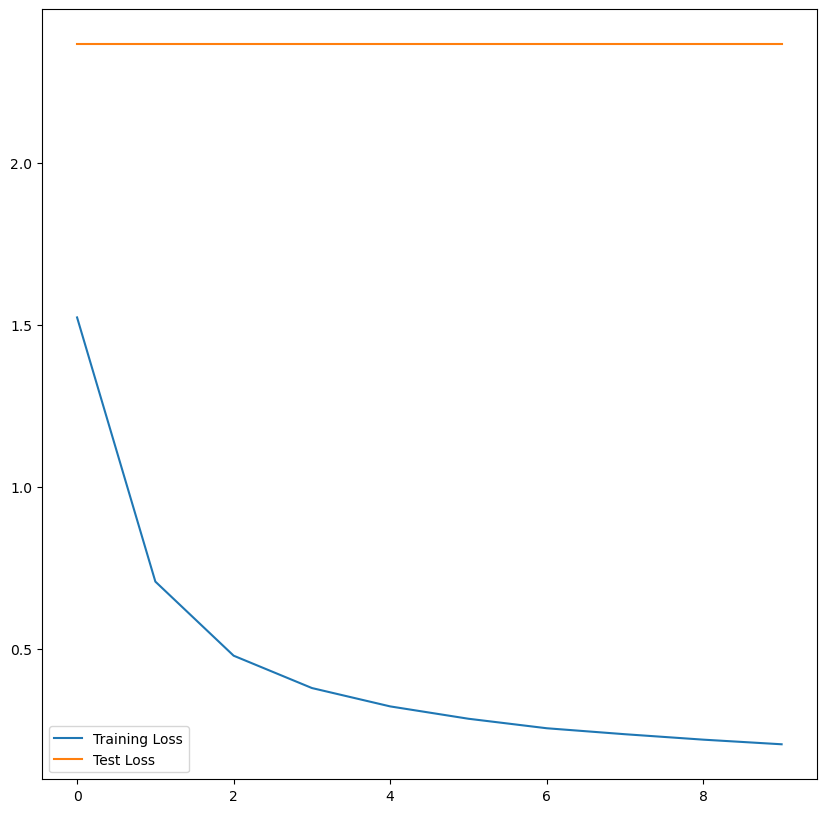

In [62]:
# Loss
f = plt.figure(figsize=(10, 10))
plt.plot(train_loss, label="Training Loss")
plt.plot(test_loss, label="Test Loss")
plt.legend()
plt.show()

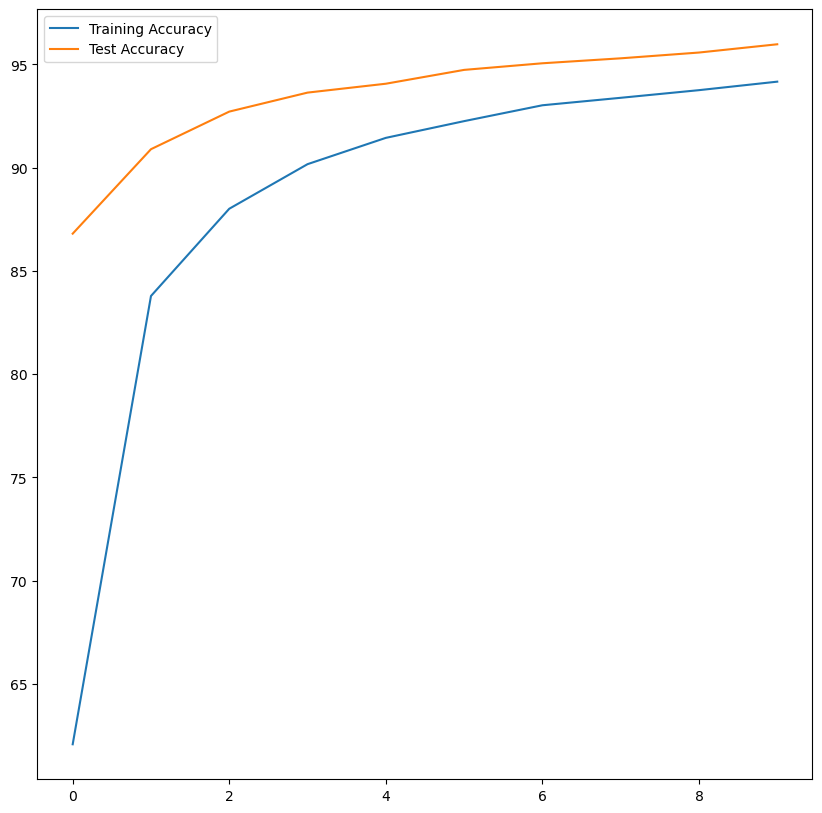

In [60]:
# Accuracy
f = plt.figure(figsize=(10, 10))
plt.plot(train_accuracy, label="Training Accuracy")
plt.plot(test_accuracy, label="Test Accuracy")
plt.legend()
plt.show()

In [61]:
img = test_dataset[30][0].resize_((1, 1, 28, 28)) # (batch_size, channels, height, width)
label = test_dataset[30][1]

if CUDA:
    model = model.cuda()
    img = img.cuda()

output = model(img)
_, predicted = torch.max(output, 1)
print(f"Prediction is: {predicted.item()}")
print(f"Actual is: {label}")

Prediction is: 3
Actual is: 3
